# LZ78 Usage Tutorial: Sequential Probability Assignment (SPA)

**Note**: please look at `Sequences.ipynb` first if you haven't already.

## Prerequisites
1. Follow the setup instructions in `tutorials/README.md`
2. In the same Python environment as you used for that tutorial, run `pip install ipykernel`
3. Use that Python environment as the kernel for this notebook.

## Important Note
Sometimes, Jupyter doesn't register that a cell containing code from the `lz78` library has started running, so it seems like the cell is waiting to run until it finishes.
This can be annoying for operations that take a while to run, and **can be remedied by putting `stdout.flush()` at the beginning of the cell**.

## Imports

In [1]:
from lz78 import Sequence, LZ78SPA, spa_from_file, CharacterMap
import os
import requests
from sys import stdout
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import pretty_print

## LZ78 SPA

The `LZ78SPA` class is the implementation of the family of sequential probability assignments discussed in [A Family of LZ78-based Universal Sequential Probability Assignments](https://arxiv.org/abs/2410.06589), for Dirichelt priors.

Under this prior, the sequential probability assignment is an additive
perturbation of the emprical distribution, conditioned on the LZ78 prefix
of each symbol (i.e., the probability model is proportional to the
number of times each node of the LZ78 tree has been visited, plus gamma).

This SPA has the following capabilities:
- training on one or more sequences,
- log loss ("perplexity") computation for test sequences,
- SPA computation (using the LZ78 context reached at the end of parsing
    the last training block),
- sequence generation.

Note that the LZ78SPA does not perform compression; see `CompressorTutorial.ipynb` for how to perform LZ78 compression.

## 1. Basic SPA Capabilities
First, we go over the main capabilities of the LZ78 SPA, using the text of a Sherlock Holmes novel as an example.

In [3]:
text = requests.get("https://www.gutenberg.org/cache/epub/1661/pg1661.txt").text

Let's define our own character map and filter the text based on this.

In [4]:
stdout.flush()
charmap = CharacterMap("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ. ,?\n\"';:\t-_")
filtered_text = charmap.filter_string(text)

Let us divide the text into a training and test split, each with 5 sequences.

In [5]:
SEQ_LEN = len(filtered_text) // 10
train_text = [filtered_text[i*SEQ_LEN:(i+1)*SEQ_LEN] for i in range(5)]
test_text = [filtered_text[i*SEQ_LEN:(i+1)*SEQ_LEN] for i in range(5,10)]

### 1.1 SPA Initialization
To initialize an LZ78 SPA, you need to pass in the alphabet size of the sequences you plan to model with the SPA.

You can also pass in these optional parameters:
- `gamma` (default: `0.5`): this is the Dirichlet smoothing parameter of the SPA (see Section 2 for more details).

    For alphabet size $A$, $\frac{1}{A-1}$ can be a good heuristic for `gamma`, but is not guaranteed to work in all cases.
- `compute_training_loss` (default: `True`): to save computation, you can choose to not compute the SPA log loss during training by setting `compute_training_loss=False`.

In [ ]:
spa = LZ78SPA(alphabet_size=charmap.alphabet_size(), gamma=1/(charmap.alphabet_size()-1))

### 1.2 SPA Training

You can train the LZ78 SPA via the `train_on_block` function, which takes in a `Sequence` as an input. This function returns the total log loss incurred when training on the input sequence.

Optionally, call `spa.reset_state()` before `train_on_block` to return to the root in between input sequences (_note_: inference always starts at the root without having to call `reset_state`, but subsequent training resumes from the node where it left off).

In [ ]:
stdout.flush()

EPOCHS = 10
for _ in tqdm(range(EPOCHS)):
    for seq in train_text:
        spa.reset_state()
        spa.train_on_block(Sequence(seq, charmap=charmap))

#### **Freezing the Tree Structure**
By passing in `freeze_tree=True` to `train_on_block`, you can update the counts without adding new leaves.

In [ ]:
for seq in train_text:
    spa.reset_state()
    spa.train_on_block(Sequence(seq, charmap=charmap), freeze_tree=True)

#### **Pruning**
The SPA can also be pruned via the `prune` instance method. This can be used to reduce memory usage, but generally reduces SPA accuracy.

In [ ]:
# # Uncomment to prune the SPA
# spa.prune(min_count=1) # this prunes any nodes that have not been visited

### 1.3 Basic SPA Inference

Inference is performed using the `compute_test_loss` function, which takes in a `Sequence` as input.
`compute_test_loss` returns a dictionary with the following fields:
- `avg_log_loss`: log loss, averaged over symbols in the input sequence
- `avg_perplexity`: $2^\text{log loss}$, averaged over symbols in the input sequence
- `log_losses` (only output if you pass in `output_per_symbol_losses=True` or `output_prob_dists=True`): log loss per symbol in the input sequence
- `prob_dists` (only output if you pass in `output_prob_dists=True`): SPA for each symbol in the input sequence
- `patch_info` (only output if you pass in `output_patch_info=True`): for each path taken from the root of the LZ78 tree to a leaf, the `patch_info` keeps track of what input symbols were involved in the traversal.
    This output is a list of tuples of (traversal start index, traversal end index), where the end index is exclusive.

    These "patches" may overlap if "backshift parsing" occurs (see below for a short description).

#### Backshift Parsing:

When we try to perform inference at the root or a leaf of the LZ78 tree, there is not enough information availble to produce a good probability estimate for the next symbol (leaves have not seen any symbols and thus have uniform SPA values, and the root does not take past context into consideration).
So, instead of trying to perform inference at the root or leaf of the tree, we perform **backshift parsing** or **node relocation**:
- Starting at some `backshift_ctx_len` indices before the current symbol, traverse the tree starting from the root until the current symbol
- If we ever reach a leaf during this process, retry with a context of length `backshift_ctx_len - 1`. If that fails, try `backshift_ctx_len - 2`, etc.
- Once we traverse to the curret symbol without reaching a leaf, we can continue inference as usual.

Backshift parsing is enabled by default with `backshift_ctx_len = 5`.

#### **Basic Inference Example:**

In [ ]:
stdout.flush()
res = spa.compute_test_loss(Sequence(test_text[0], charmap=charmap))
res

#### **Outputting Per-Symbol Log Losses:**

In [ ]:
stdout.flush()
res = spa.compute_test_loss(
    Sequence(test_text[0][:100], charmap=charmap),
    output_per_symbol_losses=True
)
log_losses = res['log_losses']

plt.figure(figsize=(12,3))
plt.stem(log_losses, "b")
plt.grid(True)
plt.xlabel("Index", fontdict={"size": 14})
plt.ylabel("Log Loss", fontdict={"size": 14})
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Per-Symbol Log Loss of LZ78 SPA", fontdict={"size": 18})
plt.show()

#### **Outputting SPAs for each index of the test sequence:**

In [ ]:
stdout.flush()
res = spa.compute_test_loss(
    Sequence(test_text[0][:100], charmap=charmap),
    output_prob_dists=True
)

In [ ]:
IDX = 15
prob_dist = res['prob_dists'][IDX]

plt.figure(figsize=(15,3))
plt.stem(prob_dist, "r")
plt.grid(True)
x = list(range(len(prob_dist)))
plt.xticks(ticks=x, labels=charmap.decode(list(x)), size=12)
plt.yticks(size=12)
plt.ylabel("SPA Value", fontdict={"size": 14})
plt.title(f"Probability of each symbol at index {IDX}\n(actual next symbol: \"{test_text[0][IDX]}\", \
log loss: {round(res['log_losses'][IDX], 4)})", fontdict={"size": 18})
plt.show()

#### **Outputting root-to-leaf traversal information:**

In [ ]:
stdout.flush()
res = spa.compute_test_loss(
    Sequence(test_text[0][:25], charmap=charmap),
    output_patch_info=True
)
for i, info in enumerate(res['patch_info']):
    print(f"Traversal {i} uses indices {info[0]} through {info[1] - 1}")

### 1.4 SPA Inference Features: Context and Parallelism

LZ78 SPA Inference also supports passing in a **context**, which is a `Sequence` that is assumed to occur directly before the input on which the test log loss is being computed.
This context is used for backshift parsing.

In [ ]:
stdout.flush()
res = spa.compute_test_loss(
    input=Sequence(test_text[0][5:], charmap=charmap),
    context=Sequence(test_text[0][:5], charmap=charmap)
)
res

#### **Parallelism**
Inference on multiple test sequences can be performed in parallel using the function `compute_test_loss_parallel`, which takes in a list of input sequences and returns a list of output dictionaries.

A context can also be provided for parallel inference; in that case, a context must be provided for each input sequence: the `context` argument is a list of the same legth as the `input` argument.

In [ ]:
inputs = [Sequence(seq[5:], charmap=charmap) for seq in test_text]
contexts = [Sequence(seq[:5], charmap=charmap) for seq in test_text]

stdout.flush()
res = spa.compute_test_loss_parallel(
    inputs, contexts, num_threads=8
)
print("Log losses: ", [r['avg_log_loss'] for r in res])

### 1.5 Generation

The `generate_data` method generates a sequence from the SPA, using temperature and top-k sampling.

It takes in as arguments:
- **len**: number of symbols to generate
- **seed_data**: you can specify that the sequence of generated data
    be the continuation of the specified sequence.
- **temperature**: a measure of how "random" the generated sequence is. A
    temperature of 0 deterministically generates the most likely
    symbols, and a temperature of 1 samples directly from the SPA.
    Temperature values around 0.1 or 0.2 function well.
- **top_k**: forces the generated symbols to be of the top_k most likely
    symbols at each timestep.

Returns a tuple of the generated sequence and that sequence's log loss,
or perplexity.

In [ ]:
SEED_DATA = "This "

stdout.flush()
(generated, log_loss) = spa.generate_data(
    len=1000, seed_data=Sequence(SEED_DATA, charmap=charmap),
    temperature=0.1, top_k=5
)

In [ ]:
pretty_print(SEED_DATA + generated.get_data())

## 2. SPA Configuration

For inference and generation, there are some hyperparameters that can be tuned for SPA accuracy.

### 2.1 Configuration settings:
- `gamma`: this is the "Dirichlet smoothing parameter," which perturbs the probability model at each node of the LZ78 tree from empirical distribution of symbols seen at that node.

    A higher value of `gamma` means that the probability models at each node tend more towards a uniform distribution. $\frac{1}{A-1}$, where $A$ is the size of the alphabet, is a good heuristic but might not work well in all cases.

    **Possible values:** floats > 0

    **Default**: `0.5`

- `adaptive_gamma`: whether to scale `gamma` to be smaller for deeper nodes, or for nodes that have seen fewer symbols.

    **Possible values:**
    - `"disabled"`
    - `"inverse"`: smaller `gamma` for deeper nodes. The motivation for this is that deeper nodes have a longer context, so their empirical distributions can be "trusted" more.
    - `"count"`: smaller `gamma` for nodes that have seen fewer symbols. This protects against Dirichlet regulatization that is too aggressive for nodes that have seen fewer symbols but not strong enough for nodes that have been traversed many times.

    **Default:** `"disabled"`

- `temp`: temperature parameter, where temperature is applied as $\text{SPA}(a) \gets \frac{\text{exp}\left\{\log\left(\text{SPA}(a)\right)/T\right\}}{\sum_{b < A} \text{exp}\left\{\log\left(\text{SPA}(b)\right)/T\right\}}$ (where $T$ is the temperature parameter).

    **Possible values:** floats >= 0

    **Default:** `1` (same as no temperature applied)

- `lb`: lower bound on the probability values from the SPA (if any value is too close to zero, it is set to this value).

    **Possible values:** floats >= 0

    **Default:** `0.0001`

- `lb_or_temp_first`: whether to apply lower bound or temperature first.

    **Possible values:** `"lb_first"`, `"temp_first"`, `"disabled"`

    **Default:** `"lb_first"`

- `backshift_parsing`: boolean for whether to enable backshift parsing. In backshift parsing, whenever we reach a leaf, we return to the root of the tree and use the most recently-seen symbols to traverse the tree, hopefully arriving at a location with a more accurate SPA. See Section 1.3 for a more detailed description of the procedure.

    **Possible values:** booleans

    **Default:** `True`

- `backshift_ctx_len`: length of the context of recetly-seen symbols to use for backshift parsing.

    **Possible values:** integers >= 1

    **Default:** `5`

- `backshift_break_at_phrase`: whether to continue backshift parsing at a certain shift after a return to the root, or to move on to the next shift.

    **Possible values:** booleans

    **Default:** `True`

- `ensemble_type`: If **ensemble inference** is enabled, then the SPA is evaluated at several nodes of different depths (corresponding to contexts of different lengths). This typically trades off inference accuracy with inference speed.

    **Possible values:**
    - `"disabled"`
    - `"average"`: average the ensemble SPAs
    - `"entropy"`: weight the average based on the entropy of each SPA
    - `"depth"` to weight the average based on the node depths

    **Default:** `"disabled"`

- `ensemble_n`: maximum number of nodes to use for the ensemble.

    **Possible values:** integers >= 1

    **Default:** `1`

Much of these options come from [chwoong/lz](https://github.com/chwoong/lz/tree/master).

### 2.2 Printing out current inference and generation config
Note that the lower bound and temperature are not part of the generation config, as temperature and topk is already passed into the `generate_data` function.

In [ ]:
spa.get_inference_config()

In [ ]:
spa.get_generation_config()

### 2.3 Setting inference and generation config

The following set of parameters may work well for inference.

In [ ]:
spa.set_inference_config(
    lb=1e-5,
    temp=1,
    lb_or_temp_first="lb_first",
    ensemble_type="depth",
    ensemble_n=6,
    backshift_parsing=True,
    backshift_ctx_len=10,
    backshift_break_at_phrase=True
)

In [ ]:
spa.set_generation_config(
    ensemble_type="depth",
    ensemble_n=5,
    backshift_parsing=True,
    backshift_ctx_len=10,
    backshift_break_at_phrase=True
)

#### **Testing out inference with these parameters:**

In [ ]:
inputs = [Sequence(seq[10:], charmap=charmap) for seq in test_text]
contexts = [Sequence(seq[:10], charmap=charmap) for seq in test_text]

stdout.flush()
res = spa.compute_test_loss_parallel(
    inputs, contexts, num_threads=8
)
print("Log losses: ", [r['avg_log_loss'] for r in res])

#### **Testing out generation with these parameters:**

Tuning hyperparameters typically results in less of a qualitative improvement for generation.

In [ ]:
SEED_DATA = "This "

stdout.flush()
(generated, log_loss) = spa.generate_data(
    len=1000, seed_data=Sequence(SEED_DATA, charmap=charmap),
    temperature=0.1, top_k=5
)

In [ ]:
pretty_print(SEED_DATA + generated.get_data())

## 3. Saving the SPA to Disk

The SPA can be saved to a file using the `to_file` instance method.

In [ ]:
os.makedirs("test_data", exist_ok=True)
stdout.flush()
spa.to_file("test_data/SPAoutput.bin")

It can be loaded from a file via the `spa_from_file` function.

In [ ]:
stdout.flush()
loaded_spa = spa_from_file("test_data/SPAoutput.bin")

In [ ]:
stdout.flush()
res1 = loaded_spa.compute_test_loss(Sequence(test_text[0], charmap=charmap))
res2 = spa.compute_test_loss(Sequence(test_text[0], charmap=charmap))
assert res1 == res2

## 4. Debugging Features
### 4.1 Leaf Depths
By passing in `return_leaf_depths=True` to `train_on_block`, the function will return a list with the depth of each new leaf added.

In [6]:
stdout.flush()
spa = LZ78SPA(alphabet_size=charmap.alphabet_size(), gamma=1/(charmap.alphabet_size()-1))
res = spa.train_on_block(Sequence("".join(train_text), charmap=charmap), return_leaf_depths=True)

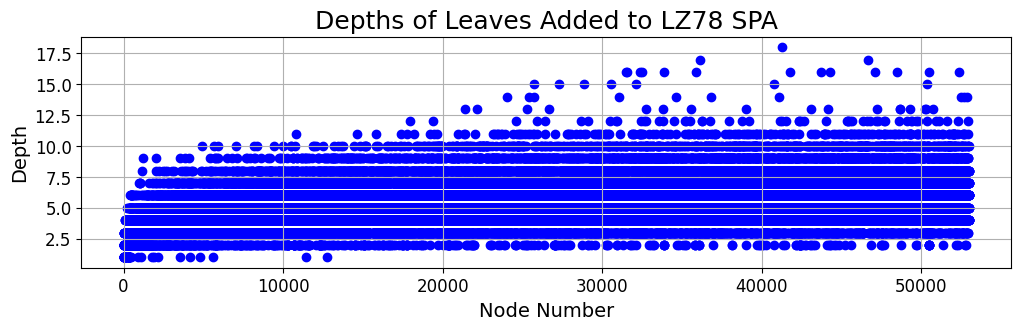

In [7]:
leaf_depths = res['leaf_depths']

plt.figure(figsize=(12,3))
plt.scatter(range(len(leaf_depths)), leaf_depths, c="b")
plt.grid(True)
plt.xlabel("Node Number", fontdict={"size": 14})
plt.ylabel("Depth", fontdict={"size": 14})
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Depths of Leaves Added to LZ78 SPA", fontdict={"size": 18})
plt.show()

**Sanity check**: if the tree is frozen, no new leaves are added.

In [8]:
res = spa.train_on_block(Sequence("".join(train_text), charmap=charmap),
                         return_leaf_depths=True, freeze_tree=True)
assert len(res["leaf_depths"]) == 0

### 4.2 Total Counts and Nodes
The instance method `get_total_counts` returns the total number of symbols the SPA has been trained on, and `get_total_nodes` returns the number of nodes in the tree.

In [10]:
spa = LZ78SPA(alphabet_size=charmap.alphabet_size(), gamma=1/(charmap.alphabet_size()-1))
res = spa.train_on_block(Sequence("".join(train_text), charmap=charmap))

In [13]:
count = spa.get_total_counts()
assert count == len("".join(train_text))
count

286880

In [14]:
spa.get_total_nodes()

53005